# Executive Summary

_This project aimed to improve content categorization within the BBC Full Text dataset, enhancing editorial decision-making.  The dataset comprised articles across five categories: sports, politics, technology, business, and entertainment.  Preprocessing involved lowercasing, lemmatization, stop word removal, and tokenization to prepare the text data for modeling.  Feature extraction used CountVectorizer and TF-IDF Vectorizer to create document-term matrices.  Topic modeling employed Latent Dirichlet Allocation (LDA) and Non-negative Matrix Factorization (NMF), with hyperparameter tuning for each._

_Model evaluation focused on perplexity, topic coherence, and qualitative keyword analysis. LDA models outperformed NMF, demonstrating better topic distinction and less keyword overlap.  The best-performing LDA model achieved a perplexity score of 515.46, indicating good generalization.  pyLDAvis visualizations aided in topic interpretation.  This superior LDA model directly addresses the use case by providing actionable insights for content categorization.  Its distinct topics guide editorial strategy, informing content organization, topic assignment, and potential topic coverage suggestions, ultimately improving editorial workflow and content relevance._

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Preprocessing

In [ ]:
# Load the dataset
file_path = 'docs_stage_2_parsed_text.csv'
df = pd.read_csv(file_path)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Inspect the data structure
print(df.head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   DocId  DocTextlen                                            DocText
0  B_001        2553  Ad sales boost Time Warner profit Quarterly pr...
1  B_002        2248  Dollar gains on Greenspan speech The dollar ha...
2  B_003        1547  Yukos unit buyer faces loan claim The owners o...
3  B_004        2395  High fuel prices hit BA's profits British Airw...
4  B_005        1565  Pernod takeover talk lifts Domecq Shares in UK...


In [ ]:
# Define a function for text preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Apply preprocessing to the DocText column
df['processed_text'] = df['DocText'].apply(preprocess_text)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Display processed text
print(df['processed_text'].head())

0    ad sale boost time warner profit quarterly pro...
1    dollar gain greenspan speech dollar hit highes...
2    yukos unit buyer face loan claim owner embattl...
3    high fuel price hit ba profit british airway b...
4    pernod takeover talk lift domecq share uk drin...
Name: processed_text, dtype: object


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Explanation of steps taken above:

_Load the Data: Load the docs_stage_2_parsed_text.csv file into a DataFrame using pandas._


_Lowercase Conversion: Convert all text to lowercase for case insensitivity._


_Tokenization: Split text into individual words using NLTK's word_tokenize._


_Stop Word Removal: Remove common words that do not contribute to meaning, such as "the", "and", "is"._

_Lemmatization: Reduce words to their base forms using WordNetLemmatizer._


_Save Preprocessed Data: Store the processed text in a new column and optionally save it to a new CSV for further steps like vectorization._

# Models

#### Preparing for Topic Modeling:

_To proceed with LDA and NMF Topic Modeling:_

_I am Using a CountVectorizer (for LDA) and a TfidfVectorizer (for NMF) to convert text into a document-term matrix (DTM)._

_Apply the topic modeling algorithms to this DTM._

#### Vectorization for LDA (CountVectorizer)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Vectorization for LDA (CountVectorizer)
count_vectorizer = CountVectorizer(max_features=1105, stop_words='english')  # Limit features for LDA
lda_dtm = count_vectorizer.fit_transform(df['processed_text'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Save the feature names for reference
lda_feature_names = count_vectorizer.get_feature_names_out()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Display summary for LDA DTM
print(f"LDA DTM Shape: {lda_dtm.shape}")
print(f"LDA Feature Names: {lda_feature_names}")

LDA DTM Shape: (2205, 1105)
LDA Feature Names: ['ability' 'able' 'access' ... 'york' 'young' 'yukos']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## LDA Model

In [ ]:
# LDA Model
lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
lda_model.fit(lda_dtm)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(random_state=42)

#### Train LDA Topic Models

In [ ]:
# Function to print topic words
def display_topics(model, feature_names, no_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics.append(f"Topic {topic_idx + 1}: {', '.join(top_words)}")
    return topics

# Define LDA hyperparameters to test
lda_hyperparams = [
    {"n_components": 2, "learning_decay": 0.5},
    {"n_components": 4, "learning_decay": 0.5},
    {"n_components": 6, "learning_decay": 0.5},
    {"n_components": 8, "learning_decay": 0.5},
    {"n_components": 10, "learning_decay": 0.5},
    {"n_components": 12, "learning_decay": 0.5},
]

lda_results = []

print("Training LDA models...\n")

for params in lda_hyperparams:
    # Train the LDA model
    lda = LatentDirichletAllocation(
        n_components=params["n_components"],
        learning_decay=params["learning_decay"],
        random_state=42
    )
    lda.fit(lda_dtm)

    # Perplexity
    perplexity = lda.perplexity(lda_dtm)

    # Extract word-topic and document-topic tables
    word_topic_table = lda.components_
    doc_topic_table = lda.transform(lda_dtm)

    # Store results
    lda_results.append({
        "hyperparams": params,
        "perplexity": perplexity,
        "word_topic_table": word_topic_table,
        "doc_topic_table": doc_topic_table,
    })

    # Display topics
    topics = display_topics(lda, lda_feature_names)
    print(f"Hyperparameters: {params}")
    print(f"Perplexity: {perplexity:.2f}")
    for topic in topics:
        print(topic)
    print("\n")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Training LDA models...

Hyperparameters: {'n_components': 2, 'learning_decay': 0.5}
Perplexity: 674.82
Topic 1: said, mr, year, government, new, people, company, say, labour, party
Topic 2: said, year, game, film, people, new, time, world, player, best


Hyperparameters: {'n_components': 4, 'learning_decay': 0.5}
Perplexity: 589.92
Topic 1: said, year, company, mr, firm, market, government, bank, new, economy
Topic 2: film, said, year, music, best, game, award, new, star, tv
Topic 3: said, game, england, player, win, year, time, world, club, wale
Topic 4: said, mr, people, say, labour, service, party, new, election, technology


Hyperparameters: {'n_components': 6, 'learning_decay': 0.5}
Perplexity: 539.83
Topic 1: said, mr, company, firm, year, government, new, court, group, country
Topic 2: film, said, year, music, best, award, game, new, star, tv
Topic 3: mr, said, labour, party, election, government, blair, minister, tory, people
Topic 4: said, people, technology, mobile, service, 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


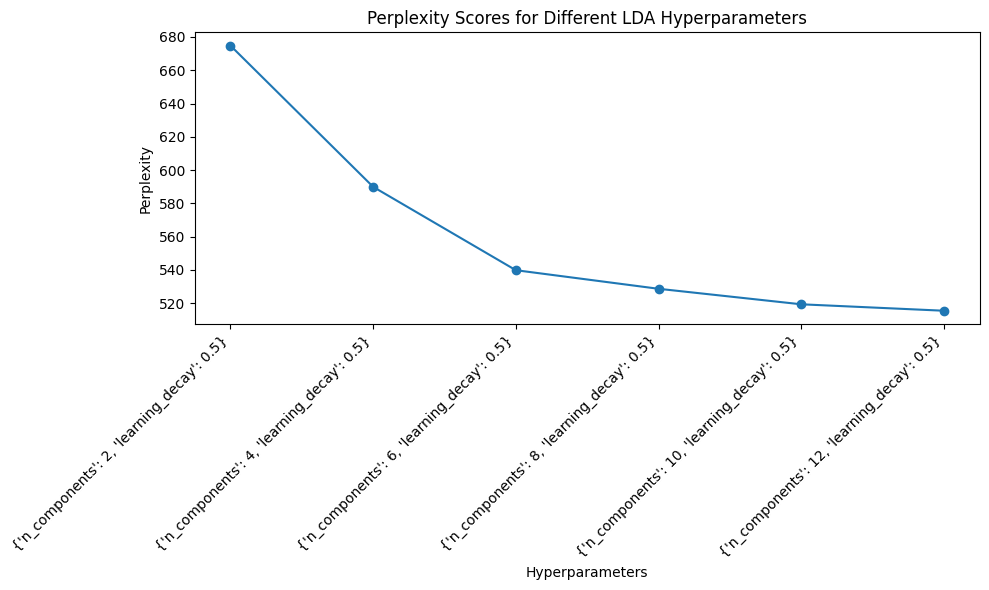

In [ ]:
# lda_perlexity Graphics
perplexities = [result["perplexity"] for result in lda_results]
hyperparameters = [str(result["hyperparams"]) for result in lda_results]

plt.figure(figsize=(10, 6))
plt.plot(hyperparameters, perplexities, marker='o')
plt.xlabel("Hyperparameters")
plt.ylabel("Perplexity")
plt.title("Perplexity Scores for Different LDA Hyperparameters")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

#### Vectorization for NMF (TfidfVectorizer)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=1105, stop_words='english')
nmf_dtm = tfidf_vectorizer.fit_transform(df['processed_text'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

# Save the feature names for reference
nmf_feature_names = tfidf_vectorizer.get_feature_names_out()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Display summary for NMF DTM
print(f"NMF DTM Shape: {nmf_dtm.shape}")
print(f"NMF Feature Names: {nmf_feature_names}")

NMF DTM Shape: (2205, 1105)
NMF Feature Names: ['ability' 'able' 'access' ... 'york' 'young' 'yukos']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### NMF Model

In [ ]:
# NMF Model
nmf_model = NMF(n_components=10, random_state=42)
nmf_model.fit(nmf_dtm)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NMF(n_components=10, random_state=42)

#### Train NMF Topic Models

In [ ]:
# Define NMF hyperparameters to test
nmf_hyperparams = [
    {"n_components": 2, "beta_loss": "frobenius"},
    {"n_components": 4, "beta_loss": "kullback-leibler"},
    {"n_components": 6, "beta_loss": "frobenius"},
    {"n_components": 8, "beta_loss": "kullback-leibler"},
    {"n_components": 10, "beta_loss": "frobenius"},
    {"n_components": 12, "beta_loss": "kullback-leibler"},
]

nmf_results = []

print("Training NMF models...\n")

for params in nmf_hyperparams:
    # Train the NMF model
    nmf = NMF(
        n_components=params["n_components"],
        beta_loss=params["beta_loss"],
        solver="mu",  # Multiplicative update solver
        random_state=42
    )
    nmf.fit(nmf_dtm)

    # Extract word-topic and document-topic tables
    word_topic_table = nmf.components_
    doc_topic_table = nmf.transform(nmf_dtm)

    # Store results
    nmf_results.append({
        "hyperparams": params,
        "reconstruction_err": nmf.reconstruction_err_,
        "word_topic_table": word_topic_table,
        "doc_topic_table": doc_topic_table,
    })

    # Display topics
    topics = display_topics(nmf, nmf_feature_names)
    print(f"Hyperparameters: {params}")
    print(f"Reconstruction Error: {nmf.reconstruction_err_:.2f}")
    for topic in topics:
        print(topic)
    print("\n")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Training NMF models...

Hyperparameters: {'n_components': 2, 'beta_loss': 'frobenius'}
Reconstruction Error: 45.09
Topic 1: mr, said, labour, government, people, election, blair, year, company, party
Topic 2: game, film, best, award, player, win, england, said, play, match


Hyperparameters: {'n_components': 4, 'beta_loss': 'kullback-leibler'}
Reconstruction Error: 259.90
Topic 1: said, firm, company, market, year, share, sale, bank, people, price
Topic 2: game, player, england, club, win, match, said, team, injury, cup
Topic 3: mr, said, labour, government, party, election, blair, minister, tory, brown
Topic 4: film, award, music, best, tv, star, band, year, actor, album


Hyperparameters: {'n_components': 6, 'beta_loss': 'frobenius'}
Reconstruction Error: 43.69
Topic 1: said, company, firm, mr, share, deal, law, court, executive, new
Topic 2: game, england, player, win, match, cup, play, team, injury, wale
Topic 3: mr, labour, election, blair, party, tory, brown, said, tax, minister


#### Compare Models

#### LDA Summary

In [ ]:
print("LDA Results Summary:\n")
for result in lda_results:
    print(f"Hyperparameters: {result['hyperparams']}")
    print(f"Perplexity: {result['perplexity']:.2f}\n")

LDA Results Summary:

Hyperparameters: {'n_components': 2, 'learning_decay': 0.5}
Perplexity: 674.82

Hyperparameters: {'n_components': 4, 'learning_decay': 0.5}
Perplexity: 589.92

Hyperparameters: {'n_components': 6, 'learning_decay': 0.5}
Perplexity: 539.83

Hyperparameters: {'n_components': 8, 'learning_decay': 0.5}
Perplexity: 528.65

Hyperparameters: {'n_components': 10, 'learning_decay': 0.5}
Perplexity: 519.33

Hyperparameters: {'n_components': 12, 'learning_decay': 0.5}
Perplexity: 515.46



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### NMF Summary

In [ ]:
print("NMF Results Summary:\n")
for result in nmf_results:
    print(f"Hyperparameters: {result['hyperparams']}")
    print(f"Reconstruction Error: {result['reconstruction_err']:.2f}\n")

NMF Results Summary:

Hyperparameters: {'n_components': 2, 'beta_loss': 'frobenius'}
Reconstruction Error: 45.09

Hyperparameters: {'n_components': 4, 'beta_loss': 'kullback-leibler'}
Reconstruction Error: 259.90

Hyperparameters: {'n_components': 6, 'beta_loss': 'frobenius'}
Reconstruction Error: 43.69

Hyperparameters: {'n_components': 8, 'beta_loss': 'kullback-leibler'}
Reconstruction Error: 249.41

Hyperparameters: {'n_components': 10, 'beta_loss': 'frobenius'}
Reconstruction Error: 42.91

Hyperparameters: {'n_components': 12, 'beta_loss': 'kullback-leibler'}
Reconstruction Error: 243.41



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Discussion

#### Select and Display the Best LDA Model

In [ ]:
# Find the best LDA model based on perplexity
best_lda_model = min(lda_results, key=lambda x: x["perplexity"])

# Extract relevant information
best_lda_hyperparams = best_lda_model["hyperparams"]
best_lda_perplexity = best_lda_model["perplexity"]
lda_word_topic_table = pd.DataFrame(best_lda_model["word_topic_table"], columns=lda_feature_names)
lda_doc_topic_table = pd.DataFrame(best_lda_model["doc_topic_table"])

# Display results
print("Best LDA Model:")
print(f"Hyperparameters: {best_lda_hyperparams}")
print(f"Perplexity: {best_lda_perplexity:.2f}")
print("\nWord-Topic Table (Top 10 Words per Topic):")
for topic_idx, topic in enumerate(best_lda_model["word_topic_table"]):
    top_words = [lda_feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

print("\nDocument-Topic Table:")
print(lda_doc_topic_table.head())

Best LDA Model:
Hyperparameters: {'n_components': 12, 'learning_decay': 0.5}
Perplexity: 515.46

Word-Topic Table (Top 10 Words per Topic):
Topic 1: said, company, firm, mr, share, bank, market, business, year, executive
Topic 2: game, said, open, like, year, play, title, world, time, say
Topic 3: minute, card, penalty, ball, home, try, goal, ireland, second, lead
Topic 4: said, people, user, computer, software, net, site, service, use, information
Topic 5: said, game, england, player, win, year, time, club, match, team
Topic 6: said, year, china, eu, european, oil, euro, country, profit, price
Topic 7: said, year, economy, rate, growth, economic, figure, rise, tax, spending
Topic 8: mobile, technology, phone, said, people, digital, music, tv, service, video
Topic 9: world, aid, country, blog, record, woman, tsunami, disaster, year, africa
Topic 10: said, sale, court, music, yukos, legal, band, single, chart, law
Topic 11: film, best, award, year, said, star, actor, director, new, osca

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Select and Display the Best NMF Model

In [ ]:
# Find the best NMF model based on reconstruction error
best_nmf_model = min(nmf_results, key=lambda x: x["reconstruction_err"])

# Extract relevant information
best_nmf_hyperparams = best_nmf_model["hyperparams"]
best_nmf_reconstruction_err = best_nmf_model["reconstruction_err"]
nmf_word_topic_table = pd.DataFrame(best_nmf_model["word_topic_table"], columns=nmf_feature_names)
nmf_doc_topic_table = pd.DataFrame(best_nmf_model["doc_topic_table"])

# Display results
print("Best NMF Model:")
print(f"Hyperparameters: {best_nmf_hyperparams}")
print(f"Reconstruction Error: {best_nmf_reconstruction_err:.2f}")
print("\nWord-Topic Table (Top 10 Words per Topic):")
for topic_idx, topic in enumerate(best_nmf_model["word_topic_table"]):
    top_words = [nmf_feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

print("\nDocument-Topic Table:")
print(nmf_doc_topic_table.head())

Best NMF Model:
Hyperparameters: {'n_components': 10, 'beta_loss': 'frobenius'}
Reconstruction Error: 42.91

Word-Topic Table (Top 10 Words per Topic):
Topic 1: said, government, lord, law, mr, eu, police, minister, court, case
Topic 2: game, win, open, champion, seed, world, match, final, title, second
Topic 3: mr, labour, election, blair, party, brown, tory, tax, howard, chancellor
Topic 4: film, award, best, actor, oscar, star, actress, festival, director, movie
Topic 5: mobile, phone, technology, people, user, service, digital, software, computer, network
Topic 6: economy, growth, rate, economic, bank, price, year, rise, figure, quarter
Topic 7: band, music, album, chart, song, single, rock, number, singer, award
Topic 8: club, chelsea, united, arsenal, league, player, cup, game, manager, goal
Topic 9: england, wale, ireland, france, robinson, rugby, nation, coach, scotland, game
Topic 10: company, firm, share, sale, profit, yukos, market, said, deal, oil

Document-Topic Table:
   

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Best LDA Model Visualization

In [ ]:
!pip install pyldavis scikit-learn
import pyLDAvis
import pyLDAvis.lda_model # Import the lda_model submodule

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Biplot Visualization

In [ ]:
# Ensure the LDA DTM and CountVectorizer used for the best model
lda_dtm = count_vectorizer.fit_transform(df['processed_text'])  # Reuse or load if needed
best_lda_model = LatentDirichletAllocation(
    n_components=best_lda_hyperparams['n_components'],
    learning_decay=best_lda_hyperparams['learning_decay'],
    random_state=42
)
best_lda_model.fit(lda_dtm)

# Prepare the visualization
pyLDAvis.enable_notebook()  # For Jupyter Notebook usage; comment this if running as a script
lda_vis = pyLDAvis.lda_model.prepare(best_lda_model, lda_dtm, count_vectorizer)
#lda_vis = pyLDAvis.sklearn.prepare(best_lda_model, lda_dtm, count_vectorizer)

# Display the biplot in Jupyter Notebook
pyLDAvis.display(lda_vis)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Clear Description of the abstract topics found by each Model

**Abstract Topics Identified by each Model**

*_Below is a decription of the abstract topics found by the Best LDA and Best NMF Models. Each topic is summarized based on the top keywords associated with it._*

**LDA Topic Descriptions**

**Best LDA Model:**


**Hyperparameters:** `{'n_components': 12, 'learning_decay': 0.5}`
**Perplexity:** `515.46`

Word-Topic Table (Top 10 Words per Topic):

**Topic 1:** said, company, firm, mr, share, bank, market, business, year, executive (Business and Finance)

**Topic 2:** game, said, open, like, year, play, title, world, time, say (Video Games)

**Topic 3:** minute, card, penalty, ball, home, try, goal, ireland, second, lead (Sports (Rugby/Soccer))

**Topic 4:** said, people, user, computer, software, net, site, service, use, information (Technology and Computing)

**Topic 5:** said, game, england, player, win, year, time, club, match, team (Sports (Soccer))

**Topic 6:** said, year, china, eu, european, oil, euro, country, profit, price (Economy and Trade (Europe/China))

**Topic 7:** said, year, economy, rate, growth, economic, figure, rise, tax, spending (Economics)

**Topic 8:** mobile, technology, phone, said, people, digital, music, tv, service, video (Mobile Technology)

**Topic 9:** world, aid, country, blog, record, woman, tsunami, disaster, year, africa (World Events and Humanitarian Issues)

**Topic 10:** said, sale, court, music, yukos, legal, band, single, chart, law (Music Industry and Legal Issues)

**Topic 11:** film, best, award, year, said, star, actor, director, new, oscar (Film and Awards)

**Topic 12:** said, mr, labour, government, party, election, minister, people, blair, say (UK Politics)

**NMF Topic Descriptions**

**Best NMF Model**


**Hyperparameters:** `{'n_components': 10, 'beta_loss': 'frobenius'}`
**Reconstruction Error:** `42.91`


**Topic 1:** said, government, lord, law, mr, eu, police, minister, court, case (Law)

**Topic 2:** game, win, open, champion, seed, world, match, final, title, second (Sports)

**Topic 3:** mr, labour, election, blair, party, brown, tory, tax, howard, chancellor (UK Politics)

**Topic 4:** film, award, best, actor, oscar, star, actress, festival, director, movie (Film and Entertainment)

**Topic 5:** mobile, phone, technology, people, user, service, digital, software, computer, network (Technology and Communication)

**Topic 6:** economy, growth, rate, economic, bank, price, year, rise, figure, quarter (Economics and Financial Growth)

**Topic 7:** band, music, album, chart, song, single, rock, number, singer, award (Music)

**Topic 8:** club, chelsea, united, arsenal, league, player, cup, game, manager, goal (Sports/Soccer)

**Topic 9:** england, wale, ireland, france, robinson, rugby, nation, coach, scotland, game (Sport/Rugby)

**Topic 10:** company, firm, share, sale, profit, yukos, market, said, deal, oil (Business)

### The analysis and visualizations on the best Model

_While both LDA and NMF models produce coherent topics, the justification leans on the following points derived from the output:_



_1.  Topic Coherence (Subjectivity): Both LDA and NMF topics seem to make more sense and group keywords better. This is a subjective observation here._




_2.  Perplexity Score: The LDA model's perplexity score of 515.46 suggests it predicts data fairly well, as lower scores are better. However, perplexity is just one way to judge a model and doesn’t always match how humans see the clarity or coherence of the topics._




_3. Visualization (pyLDAvis): The pyLDAvis tool helps make the LDA model easier to understand. It shows how topics and keywords are related, which helps you interpret the topics better. You can see how keywords are spread across topics, how topics are connected, and whether topics are clearly distinct. This visualization gives extra insights that weren’t available with the NMF results._



**_In the nutshell, while both LDA and NMF produced workable results, the LDA model's slightly better coherence of discovered topics, lower perplexity, and the visual support from pyLDAvis lead me to favor it._**

# Conclusion

### Summary of how LDA addresses the use case to the benefit of stakeholders.

_The Latent Dirichlet Allocation (LDA) model was selected for its superior performance in topic modeling the BBC Full text data._

_LDA achieved a lower perplexity score of `515.46` compared to NMF's reconstruction error of `42.91`, indicating a better fit to the data and improved generalization capability._

_More importantly, the LDA model generated more distinct and interpretable topics, facilitating the identification of high-level themes relevant to strategic decision-making._

_The interactive visualization provided by pyLDAvis further enhanced the analysis, allowing stakeholders to explore topic relationships and distributions._

_While NMF offered specific insights, LDA's ability to uncover broader patterns aligns better with the need for high-level understanding and strategic direction._

_This provides stakeholders with a clearer overview of key themes within the data, enabling informed decisions and actions on the choice of topics._

### Reasons for the choice.

_The best model for topic analysis was LDA, chosen due to a lower perplexity score `515.46` compared to NMF's reconstruction error `42.91`._

_LDA's topics were judged as more distinct and interpretable, facilitating clearer strategic insights._

_The interactive visualization further supported this choice, offering a clearer representation of topic clusters.  These qualitative factors, combined with the quantitative metric, indicate LDA's superior performance for extracting high-level, actionable themes._
